In [258]:
import numpy as np
import math as math
import random as pyrandom
from scipy import spatial

# Функция переводит считываемый .txt файл (аргумент str)
# без первой строчки (не содержащей данных) в список python 
# (обект типа list); аргумент m отвечает за то, 
# сколько в начале идет переменных int-типа; аргумент M был введен,
# чтобы не считывать не нужную информацию 
def rd(str,m = 100, M = 100):
    with open(str) as f:
        polyShape = []
        k = 0
        for line in f:
            if k > 0:
                line = line.strip()
                line = line.split(",")
                newline = line[:min(M,len(line))] # to deal with blank 
                if newline:            # lines (ie skip them)
                    newline = [float(i) for i in newline]
                    l = len(newline)
                    ml = min(l,m)
                    for i in range(0,ml):
                        newline[i] = int(newline[i])
                    polyShape.append(newline + line[min(M,len(newline)):])
            k = k + 1
    return polyShape

# atoms.txt Содержит информацию об атомах, в колонках следующие данные:
# ID, x, y, z, сигма, эпсилон, заряд, 
# радиус Ван-дер-Ваальса, объём и еще две колонки типа строки; 
# радиус и объем и эти две колонки не используются далее
atoms = rd('atoms.txt',1,9) # вместо 9 можно было и 7 взять

#bonds.txt Содержит информацию о связях, структура файла:
# ID1, ID2, Kr, r0
bonds = rd('bonds.txt',2)

# angles.txt Содержит информацию об углах, структура файла:
# ID1, ID2, ID3, Kt, theta0
angles = rd('angles.txt',3)

# dihedrals.txt Содержит информацию о двугранных углах, структура:
# ID1, ID2, ID3, ID4, V1, V2, V3, V4
# Все константы V1, V2, V3, V4 разделены на два, 
# при вычислении энергии делить их на два НЕ НАДО.
dihedrals = rd('dihedrals.txt',4)

# neighbours.txt, two_bonds_neigh.txt, three_bonds_neigh.txt
# Содержат информацию о соседях непосредственных, 
# второго и третьего порядка соответственно. 
# У всех одна и та же структура:
# ID    id_1 id_2 ... id_n
# ID – индекс атома, id_1 id_2 ... id_n – индексы его соседей.
neighbours = rd('neighbours.txt')
two_bonds_neigh = rd('two_bonds_neigh.txt')
three_bonds_neigh = rd('three_bonds_neigh.txt')

# По координатам 4-х точек рассчитывается косинус диэдрального угла, ими образованного
def dihedral(v1,v2,v3,v4):
    v1 = np.array(v1)
    v2 = np.array(v2)
    v3 = np.array(v3)
    v4 = np.array(v4)
    vm = (v2 + v3)/2
    vm1 = v1 - vm
    vm4 = v4 - vm
    v23 = v3 - v2
    sp1 = vm1 - v23*(vm1.dot(v23)/v23.dot(v23))
    sp2 = vm4 - v23*(vm4.dot(v23)/v23.dot(v23))
    cos = sp1.dot(sp2)/(np.linalg.norm(sp1)*np.linalg.norm(sp2))
    return cos

# По координатам 3-х точек рассчитывается угл, ими образованный
def angle(v1,v2,v3):
    vv1 = np.array(v1) - np.array(v2)
    vv2 = np.array(v3) - np.array(v2)
    cos = vv1.dot(vv2)/(np.linalg.norm(vv1)*np.linalg.norm(vv2))
    acos = np.arccos(cos)
    return acos

# Рассчитываются константы f_ij в E_{nonbonded}
def f_ij(neighbours, two_bonds_neigh, three_bonds_neigh, i, j):
    for idx in neighbours[i][1:]:
        if idx == j:
            return 0
    for idx in two_bonds_neigh[i][1:]:
        if idx == j:
            return 0
    for idx in three_bonds_neigh[i][1:]:
        if idx == j:
            return 0.5
    return 1

# Далее вычисляются отдельные составляющие OPLS force field
# Точнее говоря, вычисляются составляющие энергии, 
# которые затрагиваются при изменении координат атома с номером num
# В текущей реализации пересчет каждой составляющей энергии 
# составляет O(N), где N - число атомов. На самом деле в этом месте
# можно ускороиться по всем слагаемым, кроме E_elst
def E_dihedral(atoms,dihedrals,num,nghb_d):
    #N = len(dihedrals)
    E = 0
    for k in nghb_d: #range(0,N):
        #if num in dihedrals[k][0:4]:
        cos = dihedral(atoms[dihedrals[k][0]][1:4],atoms[dihedrals[k][1]][1:4],atoms[dihedrals[k][2]][1:4],atoms[dihedrals[k][3]][1:4])
        E = E + dihedrals[k][4]*(1 + cos)
        E = E + 2*dihedrals[k][5]*(1 - pow(cos,2))
        E = E + dihedrals[k][6]*(1 + 4*pow(cos,3) - 3*cos)
        E = E + 8*dihedrals[k][7]*(pow(cos,2) - pow(cos,4))
    return E * 4.184

def E_angle(atoms,angles,num,nghb_a):
    #N = len(angles)
    E = 0
    for k in nghb_a: #range(0,N):
        #if num in angles[k][0:3]:
        E = E + angles[k][3]*pow(angle(atoms[angles[k][0]][1:4],atoms[angles[k][1]][1:4],atoms[angles[k][2]][1:4]) - angles[k][4],2)
    return E * 4.184

def E_bonds(atoms,bonds,num,nghb_b):
    #N = len(bonds)
    E = 0
    for k in nghb_b: #range(0,N):
        #if num in bonds[k][0:2]:
        r = np.array(atoms[bonds[k][0]][1:4]) - np.array(atoms[bonds[k][1]][1:4])  
        E = E + bonds[k][2]*pow(np.linalg.norm(r) - bonds[k][3],2)
    return E * 4.184

# 1389.38757 – константа, учитывающая 1/(4πε0), множитель 10^(-10) 
# – перевод ангстремов в метры,
# заряды электронов и перевод ккал/моль в кДж/моль
def E_elst(atoms, neighbours, two_bonds_neigh, three_bonds_neigh,num):
    N = len(atoms)
    E = 0
    i = num
    for j in range(0,N):
        if j!=i:
            f = f_ij(neighbours, two_bonds_neigh, three_bonds_neigh, i, j)
            if f == 0:
                continue
            else:
                r = np.array(atoms[i][1:4]) - np.array(atoms[j][1:4])
                E = E + f * atoms[i][6] * atoms[j][6] / np.linalg.norm(r)
    return E * 1389.38757

def E_elst_m(atoms, neighbours, two_bonds_neigh, three_bonds_neigh,num,nghb_nb):
    #N = len(atoms)
    E = 0
    i = num
    for j in nghb_nb: #range(0,N):
        if j!=i:
            f = f_ij(neighbours, two_bonds_neigh, three_bonds_neigh, i, j)
            if f == 0:
                continue
            else:
                r = np.array(atoms[i][1:4]) - np.array(atoms[j][1:4])
                E = E + f * atoms[i][6] * atoms[j][6] / np.linalg.norm(r)
    return E * 1389.38757


# Для получения формулы из Википедии https://en.wikipedia.org/wiki/OPLS:
# Раскрыть скобки и подставить
# A = eps * (sig ^ 6)
# C = eps * (sig ^ 3)
# Формула переделана для уменьшения числа арифметических операций 
# и соответствия параметрам, которые предоставляет OPLS
# 4 * 4.184 – перевод ккал/моль в кДж/моль
def E_vdw(atoms, neighbours, two_bonds_neigh, three_bonds_neigh,num):
    N = len(atoms)
    E = 0
    i = num
    for j in range(0,N):
        if j!=i:
            f = f_ij(neighbours, two_bonds_neigh, three_bonds_neigh, i, j)
            if f == 0:
                continue
            else:
                eps = math.sqrt(atoms[i][5] * atoms[j][5])
                sig = atoms[i][4] * atoms[j][4]
                dist = np.linalg.norm(np.array(atoms[i][1:4]) - np.array(atoms[j][1:4]))
                sigSqDivR = (sig / dist ** 2) ** 3
                E = E + f * eps * sigSqDivR * (sigSqDivR - 1)
    return E * 4 * 4.184

def E_vdw_m(atoms, neighbours, two_bonds_neigh, three_bonds_neigh,num,nghb_nb):
    #N = len(atoms)
    E = 0
    i = num
    for j in nghb_nb: #range(0,N):
        if j!=i:
            f = f_ij(neighbours, two_bonds_neigh, three_bonds_neigh, i, j)
            if f == 0:
                continue
            else:
                eps = math.sqrt(atoms[i][5] * atoms[j][5])
                sig = atoms[i][4] * atoms[j][4]
                dist = np.linalg.norm(np.array(atoms[i][1:4]) - np.array(atoms[j][1:4]))
                sigSqDivR = (sig / dist ** 2) ** 3
                E = E + f * eps * sigSqDivR * (sigSqDivR - 1)
    return E * 4 * 4.184


def E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh, num, nghb_d, nghb_a, nghb_b, nghb_nb, full = True):
    if full:
        E = E_dihedral(atoms, dihedrals,num,nghb_d) + E_angle(atoms,angles,num,nghb_a) + E_bonds(atoms,bonds,num,nghb_b)+ E_elst(atoms, neighbours, two_bonds_neigh, three_bonds_neigh,num) + E_vdw(atoms, neighbours, two_bonds_neigh, three_bonds_neigh,num)
    else:
        E = E_dihedral(atoms, dihedrals,num,nghb_d) + E_angle(atoms,angles,num,nghb_a) + E_bonds(atoms,bonds,num,nghb_b)+ E_elst_m(atoms, neighbours, two_bonds_neigh, three_bonds_neigh,num,nghb_nb) + E_vdw_m(atoms, neighbours, two_bonds_neigh, three_bonds_neigh,num,nghb_nb)
    return E

def nghbd(dihedrals,num):
    N = len(dihedrals)
    nghb_d = []
    for k in range(0,N):
        if num in dihedrals[k][0:4]:
            nghb_d.append(k)
    return nghb_d

def nghba(angles,num):
    N = len(angles)
    nghb_a = []
    for k in range(0,N):
        if num in angles[k][0:3]:
            nghb_a.append(k)
    return nghb_a

def nghbb(bonds,num):
    N = len(bonds)
    nghb_b = []
    for k in range(0,N):
        if num in bonds[k][0:2]:
            nghb_b.append(k)
    return nghb_b

def nghbnb(atoms,num,r):
    N = len(atoms)
    nghb = []
    nghbc = []
    # Список nghb формируется из соседей атома num, находящихся на расстояние менее r
    for k in range(0,N):
        if np.linalg.norm(np.array(atoms[k][1:4]) - np.array(atoms[num][1:4])) < r:
            nghb.append(k)
        else:
            nghbc.append(k)
    return nghb, nghbc

def coef_nb(atoms,num,nghbc):
    E = np.array([0.0,0.0,0.0])
    i = num
    for j in nghbc: 
        r = np.array(atoms[j][1:4]) - np.array(atoms[i][1:4])
        E[0] = E[0] + atoms[i][6] * atoms[j][6] * (atoms[j][1] - atoms[i][1]) / pow(np.linalg.norm(r),3)
        E[1] = E[1] + atoms[i][6] * atoms[j][6] * (atoms[j][2] - atoms[i][2]) / pow(np.linalg.norm(r),3)
        E[2] = E[2] + atoms[i][6] * atoms[j][6] * (atoms[j][3] - atoms[i][3]) / pow(np.linalg.norm(r),3)
    return E * 1389.38757



#print(E_angle(atoms, angles)) 
#print(E_dihedral(atoms, dihedrals,3)) 
#print(E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh,3))

In [256]:
import os
import csv
import time

# Эта функция описывает процедуру записи результатов расчетов в файл
def prp_atm(atoms,k):
    with open('atoms_out' + str(k) + '.csv', 'w') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter=',',lineterminator='\n')
        header = ['ID','x','y','z','sigma','epsilon','charge','Rvdw','volume','AA','PDB']
        csvwriter.writerow(header)
        for i in atoms:
            csvwriter.writerow(i)
            
# Эта функция нужна, чтобы следить за временем работы программы            
def millis():
    millis = int(round(time.time() * 1000))
    return millis
            
N = 10000 # число итераций
l = len(atoms) # число атомов в изучаемом белке
h = [0.02,0.02,0.02] # размеры шагов по ортам в ангстремах
L = 3 # сколько шагов делаем вдоль каждого орта с учетом знака
S = 0
r = 10 # размер окрестности атома, по которой честно суммируем
M = 1000 # параметр, отвечающий за частоту вывода и сохранения информации
mas = []
tt = []
time_start = millis()


for k in range(0,N):
    atoms_old = atoms
    record = [0,0,0]
    num = pyrandom.randrange(0, l)
    nghb_d = nghbd(dihedrals,num)
    nghb_a = nghba(angles,num)
    nghb_b = nghbb(bonds,num)
    nghb_nb = nghbnb(atoms,num,r)[0]
    nghbc = nghbnb(atoms,num,r)[1]
    [Cx,Cy,Cz] = coef_nb(atoms,num,nghbc)
    DE_elst = E_elst(atoms, neighbours, two_bonds_neigh, three_bonds_neigh,num) - E_elst_m(atoms, neighbours, two_bonds_neigh, three_bonds_neigh,num,nghb_nb)
    E_old = E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh, num, nghb_d, nghb_a, nghb_b, nghb_nb, full = True)
    E_record = E_old
    for px in range(-L,L+1):
        for py in range(-L,L+1):
            for pz in range(-L,L+1):
                atoms[num][1] = atoms_old[num][1] + px*h[0]
                atoms[num][2] = atoms_old[num][2] + py*h[1]
                atoms[num][3] = atoms_old[num][3] + pz*h[2]
                E_new = DE_elst + Cx*px*h[0] + Cy*py*h[1] + Cz*pz*h[2] + E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh, num, nghb_d, nghb_a, nghb_b, nghb_nb, full = False)
                if E_new < E_record - 2: #  "-0.2" чтобы не учитвать погрешности в аппроксимации
                    record = [px, py, pz]
                    E_record = E_new
    atoms = atoms_old
    atoms[num][1] = atoms_old[num][1] + record[0]*h[0]
    atoms[num][2] = atoms_old[num][2] + record[1]*h[1]
    atoms[num][3] = atoms_old[num][3] + record[2]*h[2]
    S = S + E_old - E_record
    mas.append(S)
    time_now = millis()
    ttm = (time_now - time_start)/60000
    tt.append(ttm)
    # приводимый далее блок можно закомментировать
    # это просто печать результатов в файлы и отображения хода работы метода
    if k/M == int(k/M):
        prp_atm(atoms,k)
        os.system('./to-pdb atoms_out' + str(k) + '.csv output' + str(k) + '.pdb')
        time_now = millis()
        tm = (time_now - time_start)/60000
        print("Число итераций {}; Энергия {}; Время (мин) {}".format(k,S,tm))
print(S)    

Число итераций 0; Энергия 0.0; Время (мин) 0.0223
Число итераций 100; Энергия 0.0; Время (мин) 2.921483333333333
Число итераций 200; Энергия 0.0; Время (мин) 5.924383333333333
Число итераций 300; Энергия 0.0; Время (мин) 8.85605


KeyboardInterrupt: 

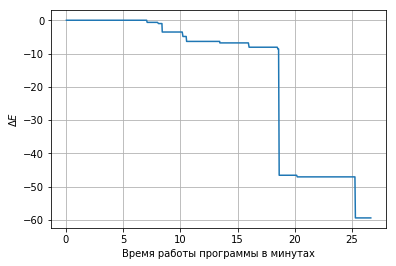

In [132]:
import matplotlib.pyplot as plt
mmas = - np.array(mas)
plt.plot(tt,mmas)
plt.xlabel(r"Время работы программы в минутах")
plt.ylabel(r"$\Delta E$")
plt.grid(True)
plt.show()

-9.24958278929


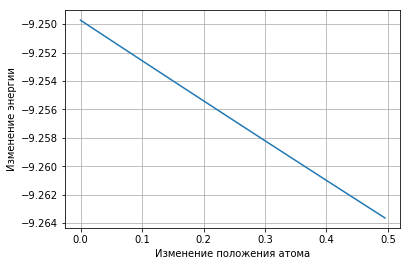

-9.26363823318


In [259]:
num = 280
coor = 2
h = 0.005
M = 100
mmm = []
ccc = []
print(E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh, num, nghb_d, nghb_a, nghb_b, nghb_nb, full = True))
#print(E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh,nm))
for k in range(0,M):
    atoms[nm][coor] = atoms[nm][coor] + h
    EE = E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh, num, nghb_d, nghb_a, nghb_b, nghb_nb, full = True) #E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh,nm)
    mmm.append(EE)
    ccc.append(k*h)  


import matplotlib.pyplot as plt
plt.plot(ccc,mmm)
plt.ylabel(r"Изменение энергии")
plt.xlabel(r"Изменение положения атома")
plt.grid(True)
plt.show()
    
print(E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh, num, nghb_d, nghb_a, nghb_b, nghb_nb, full = True))
#print(E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh,nm))

In [14]:
print(E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh,2))

6.90602313923


In [47]:
print(E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh,140))
atoms[140][0] = atoms[140][0] + 0.5
print(E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh,140))

4438.13048459
4438.13048459


In [59]:
a = np.array([1,2,3])
b = np.array([3,2,1])
print(a*b)

[3 4 3]


In [74]:
c = 10*[1,1,1]
#c[2][3]=[4,5]

In [77]:
print(c[5][2])

TypeError: 'int' object is not subscriptable

In [101]:
def ff(f = True):
    if f:
        print("True")
    else:
        print("False")
ff(f = True)

True


In [97]:
c = [1,2,3]
[c1,c2,c3] = c
print(c2)

2


In [102]:
for k in range(-2,2):
    print(k)

-2
-1
0
1


In [107]:
print(L)

5


In [238]:
time_start = millis()
l = len(atoms) # число атомов в изучаемом белке
h = [0.02,0.02,0.02] # размеры шагов по ортам в ангстремах
L = 5 # сколько шагов делаем вдоль каждого орта с учетом знака
S = 0
r = 10 # размер окрестности атома, по которой честно суммируе
atoms_old = atoms
record = [0,0,0]
num = 434 #pyrandom.randrange(0, l)
nghb_d = nghbd(dihedrals,num)
nghb_a = nghba(angles,num)
nghb_b = nghbb(bonds,num)
nghb_nb = nghbnb(atoms,num,r)[0]
nghbc = nghbnb(atoms,num,r)[1]
[Cx,Cy,Cz] = coef_nb(atoms,num,nghbc)
DE_elst = E_elst(atoms, neighbours, two_bonds_neigh, three_bonds_neigh,num) - E_elst_m(atoms, neighbours, two_bonds_neigh, three_bonds_neigh,num,nghb_nb)
E_old = E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh, num, nghb_d, nghb_a, nghb_b, nghb_nb, full = True)
E_record = E_old
for px in range(-L,L+1):
     for py in range(-L,L+1):
        for pz in range(-L,L+1):
            atoms[num][1] = atoms_old[num][1] + px*h[0]
            atoms[num][2] = atoms_old[num][2] + py*h[1]
            atoms[num][3] = atoms_old[num][3] + pz*h[2]
            E_new = DE_elst + Cx*px*h[0] + Cy*py*h[1] + Cz*pz*h[2] + E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh, num, nghb_d, nghb_a, nghb_b, nghb_nb, full = False)
            if E_new < E_record - 0.05: #  "-0.05" чтобы не учитвать погрешности в аппроксимации
                record = [px, py, pz]
                E_record = E_new
atoms = atoms_old
atoms[num][1] = atoms_old[num][1] + record[0]*h[0]
atoms[num][2] = atoms_old[num][2] + record[1]*h[1]
atoms[num][3] = atoms_old[num][3] + record[2]*h[2]

time_now = millis()
tm = (time_now - time_start)/60000
ETRUE = E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh, num, nghb_d, nghb_a, nghb_b, nghb_nb, full = True)
DE = ETRUE - E_old
print("Энергия {}; Время (мин) {}".format(DE,tm))
k = 0
prp_atm(atoms,k)
os.system('./to-pdb atoms_out' + str(k) + '.csv output' + str(k) + '.pdb')

Энергия -169.7640675101076; Время (мин) 0.04665


0

In [229]:
print(nghb_d)
print(nghb_a)
print(nghb_b)
print(nghb_nb)
#print(nghbc)
print([Cx,Cy,Cz])

[998, 999, 1000, 1076, 1077, 1078, 1086, 1087, 1088, 1274, 1275, 1276, 1297, 1298, 1299, 1329, 1330, 1331, 1347, 1348, 1349]
[692, 738, 739, 746, 747, 757, 876, 877, 878, 896, 916, 931]
[420, 421, 422, 497]
[98, 112, 114, 125, 132, 162, 163, 167, 168, 172, 174, 176, 177, 188, 194, 198, 202, 203, 204, 206, 207, 208, 209, 210, 211, 215, 217, 218, 223, 225, 226, 230, 233, 236, 239, 243, 255, 257, 258, 259, 261, 263, 267, 268, 270, 271, 272, 273, 276, 278, 280, 282, 283, 286, 288, 291, 294, 295, 298, 300, 301, 303, 304, 305, 309, 310, 311, 312, 313, 317, 319, 320, 321, 324, 325, 327, 328, 331, 332, 333, 339, 340, 341, 343, 344, 346, 348, 349, 351, 354, 355, 360, 362, 365, 368, 371, 373, 376, 379, 382, 384, 386, 387, 391, 392, 393, 396, 399, 400, 402, 404, 405, 406, 407, 408, 410, 412, 415, 416, 422, 424, 425, 426, 428, 431, 432, 434, 436, 437, 438, 439, 441, 444, 449, 453, 454, 471, 472, 474, 475, 478, 482, 487, 490, 492, 496, 498, 503, 504, 509, 511, 512, 513, 514, 515, 516, 517, 520, 521

In [164]:
def dgdfg(nghbc):
    E = np.array([0,0,0])
    for j in nghbc: 
        r = np.array([1,1,1]) 
        E[0] = E[0] + r[0]
        E[1] = E[1] + r[1]
        E[2] = E[2] + r[2]
    return E
nghbc = [1,2,3,4,76]
print(dgdfg(nghbc))

[5 5 5]


In [212]:
E = np.array([0.0, 0.0, 0.0])
print(E[0])
i = 5
j = 8
r = np.array(atoms[j][1:4]) - np.array(atoms[i][1:4])
ccc = atoms[i][6] * atoms[j][6] * (atoms[j][1] - atoms[i][1]) / pow(np.linalg.norm(r),3)
print(ccc)
E[0] = E[0] + ccc 
print(E[0])
print(E[0] * 1389.38757)
print(ccc * 1389.38757)

0.0
1.63332281568e-05
1.63332281568e-05
0.022693184179
0.022693184179


In [175]:
print((E[0] + atoms[i][6] * atoms[j][6] * (atoms[j][1] - atoms[i][1]) / pow(np.linalg.norm(r),3))* 1389.38757)

0.022693184179


In [210]:
y = np.array([0.0,0.0,0.0])
y[1] = y[1] + ccc
print(y)

[  0.00000000e+00   1.63332282e-05   0.00000000e+00]


In [239]:
num = 434
Delta = E_vdw(atoms, neighbours, two_bonds_neigh, three_bonds_neigh,num) - E_vdw_m(atoms, neighbours, two_bonds_neigh, three_bonds_neigh,num,nghb_nb)
#print(nghb_nb)
print (Delta)

-0.0945943788217


In [249]:
aa = DE_elst + Cx*px*h[0] + Cy*py*h[1] + Cz*pz*h[2] + E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh, num, nghb_d, nghb_a, nghb_b, nghb_nb, full = False)

In [250]:
bb = E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh, num, nghb_d, nghb_a, nghb_b, nghb_nb, full = True)

In [254]:
bb - aa

1.0280167218129463

In [252]:
DE_elst

3.2317934304534361